# Прогнозирование уровня средней заработной платы в России

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


## 1. Визуальный анализ ряда

Загрузим данные и построим график временного ряда

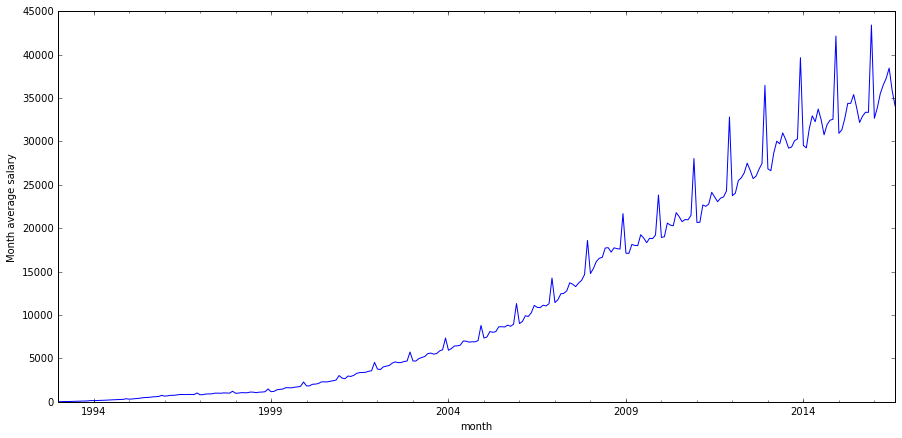

In [2]:
salary = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('Month average salary')
pylab.show()

Визуальный анализ ряда показывает, что в данных есть заметный возрастающий тренд и сезонность.
Очевидно, что он не стационарен, однако для формальности проверим стационарность с помощью критерию Дики-Фуллера, а также выполним STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


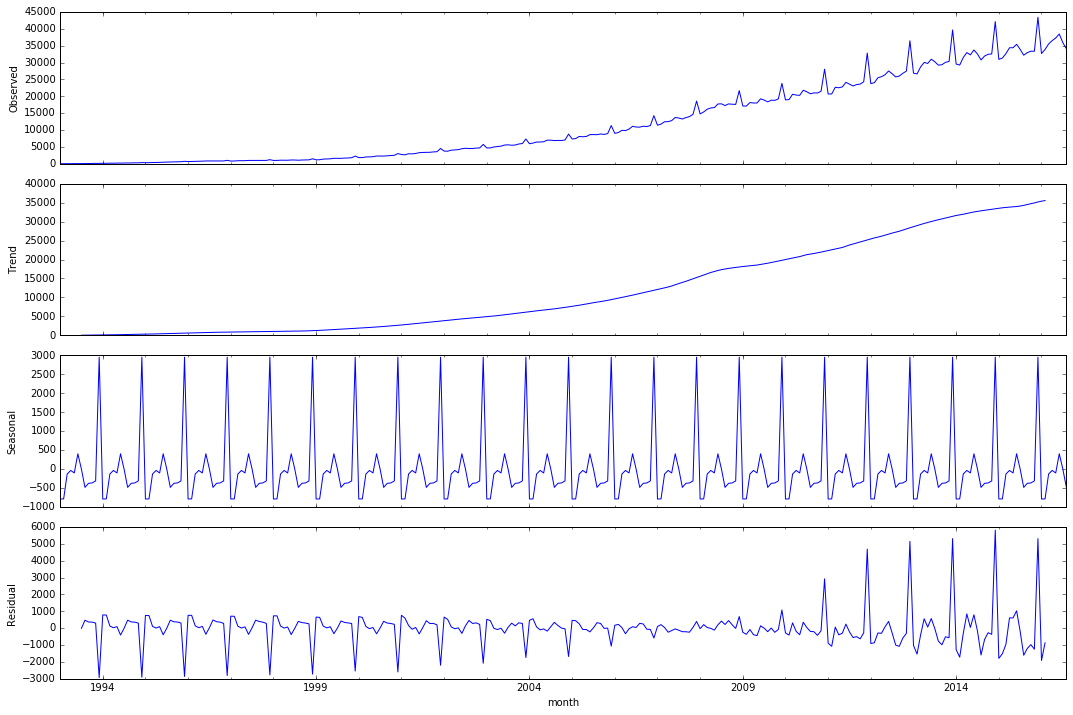

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1]

## 2. Стабилизация дисперсии

Критерий Дики-Фуллера не отвергает гипотезу нестационарности. 
Временной ряд отличается переменной дисперсией, поэтому выполним преобразование Бокса-Кокса для стабилизации дисперсии.

Оптимальный параметр преобразования Бокса-кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


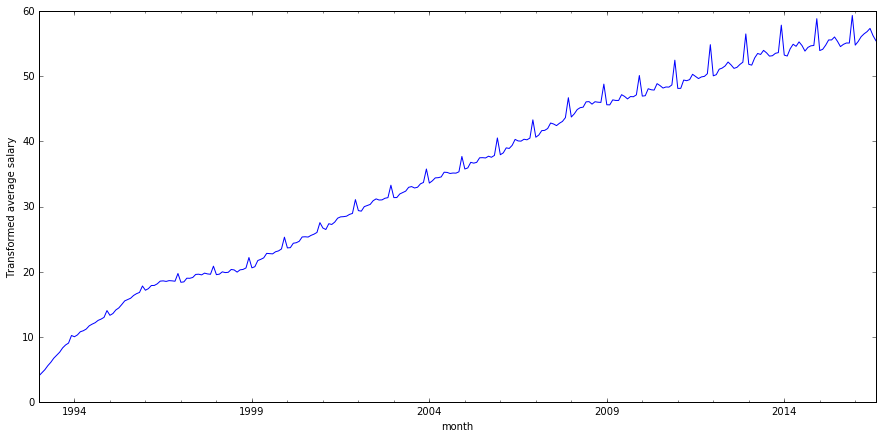

In [4]:
salary['salary_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel(u'Transformed average salary')
print "Оптимальный параметр преобразования Бокса-кокса: %f" % lmbda
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1]

## 3. Выбор порядка дифференцирования

Для приведения ряда к стационарному попробуем сезонное дифференцирование, сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


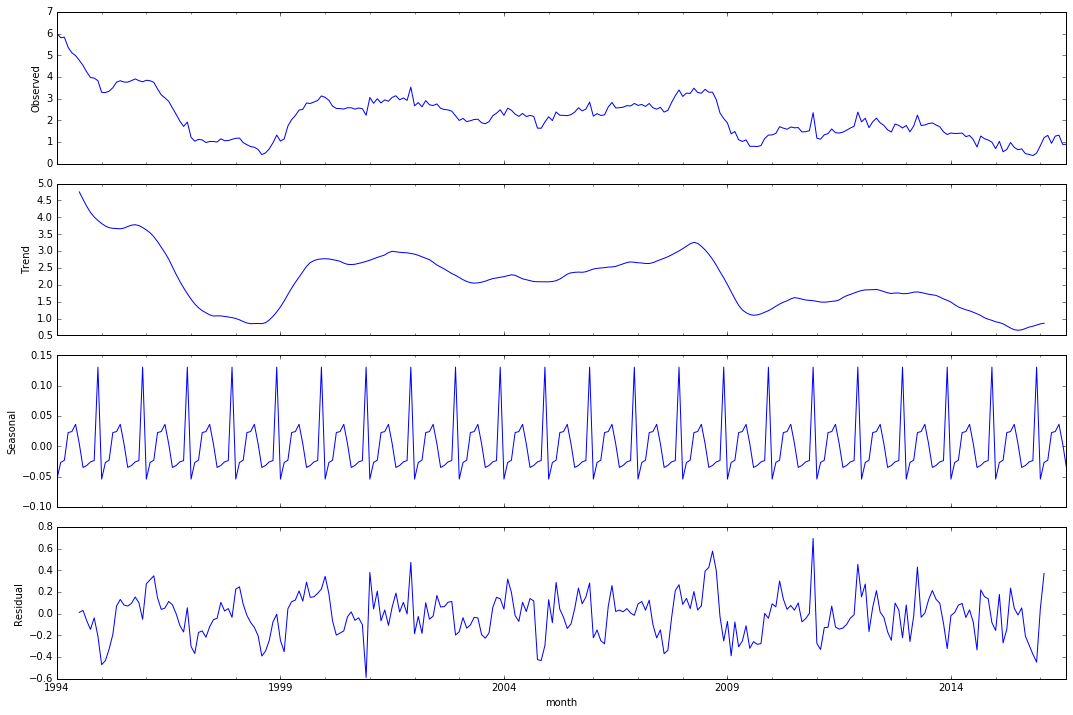

In [5]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff[12:]).plot()
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1]

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — явного тренда больше нет, однако данные выглядят довольно непредсказуемо. Применим обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


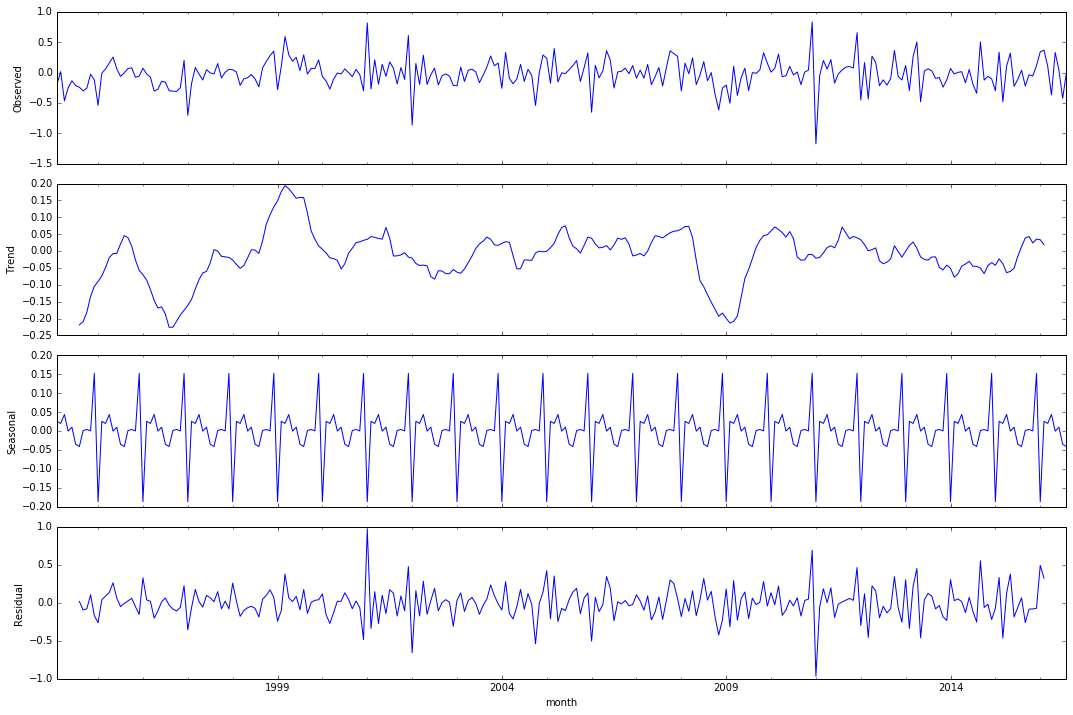

In [6]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2[13:]).plot()   
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2[13:])[1]

Гипотеза нестационарности по-прежнему отвергается, и визуально ряд выглядит еще лучше — разброс значений меньше и нет переменных повышающих и понижающих участков.

## 4. Выбор начальных приближений для p,q,P,Q

Построим графики ACF и PACF полученного ряда:

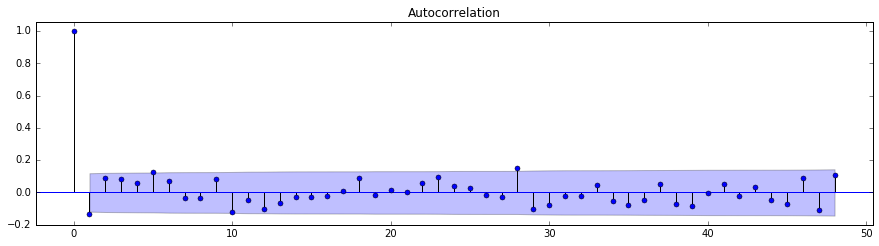

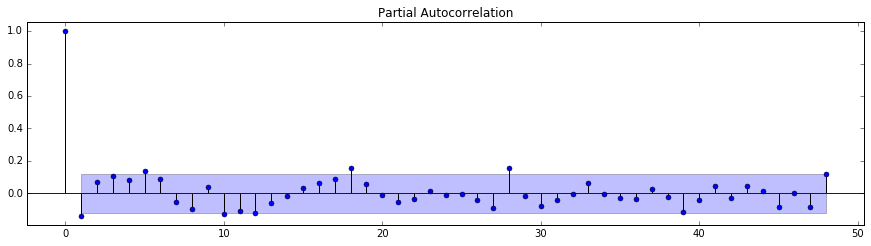

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Из расположения лагов в коррелограмме следуют начальные приближения: Q=0, q=5, P=1, p=5

## 5. Обучение и сравнение моделей-кандидатов, выбор победителя

Зададим последовательность значений параметров для перебора

In [8]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

Выполним обучениие модели на всех вариантах параметров для нахождения наилучшей про критерию AIC

In [10]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print 'wrong parameters:', param
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 1, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 4, 1, 0)


In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print result_table.sort_values(by = 'aic', ascending=True).head()

      parameters        aic
52  (5, 5, 1, 0) -25.787723
51  (5, 5, 0, 0) -21.634671
20  (1, 5, 1, 0) -15.867165
37  (3, 5, 0, 0) -14.974236
38  (3, 5, 1, 0) -14.760858


Лучшая модель:

In [12]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.894
Date:                            Sat, 01 Oct 2016   AIC                            -25.788
Time:                                    21:27:52   BIC                             18.000
Sample:                                01-01-1993   HQIC                            -8.232
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0189     17.537      0.001      0.999     -34.353      34.390
ar.L2          0.0112     11.712   

## 6. Анализ остатков построенной модели

Остатки:

Критерий Стьюдента: p=0.175582
Критерий Дики-Фуллера: p=0.000000


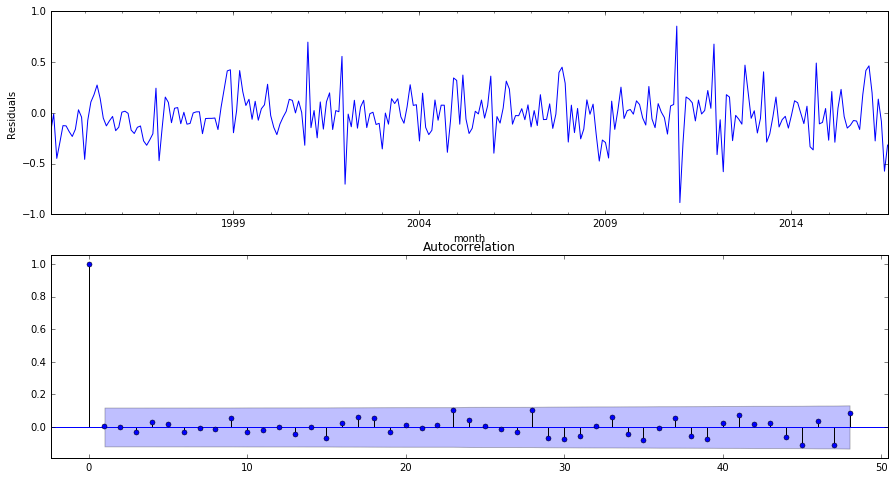

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print "Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1]
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1]

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально) и неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

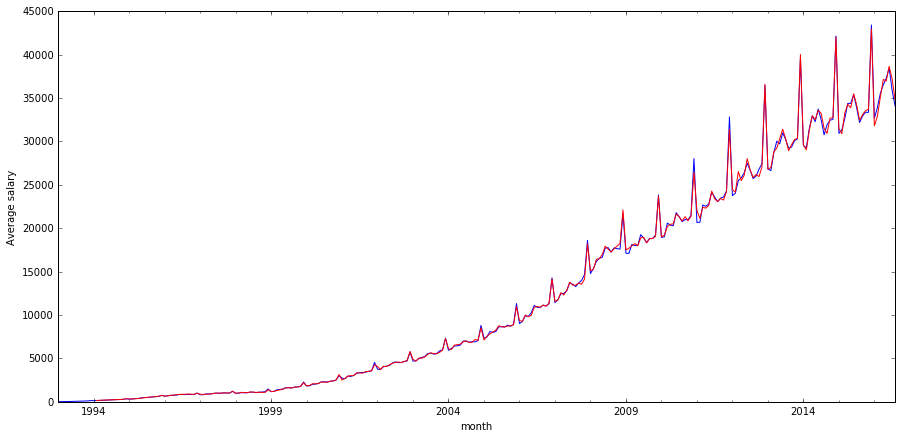

In [14]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Average salary')
pylab.show()

## 7. Прогнозирование

Построим прогноз на каждый месяц на два года вперёд от конца данных

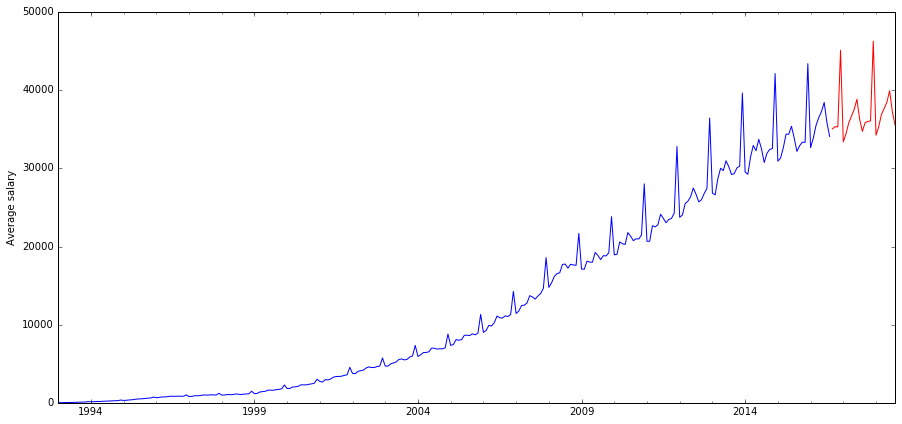

In [18]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("01.09.2016", "%d.%m.%Y") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Average salary')
pylab.show()